In [1]:
import gym

import numpy as np

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import copy
%matplotlib inline

(-0.5, 762.5, 642.5, -0.5)

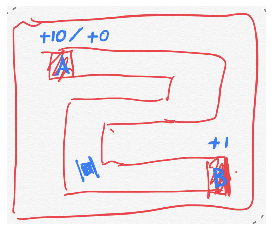

In [2]:
im = mpimg.imread("./schematic.png")
plt.imshow(im)
plt.axis("off")

In [3]:
track_sq = mpimg.imread("./track_piece.png")
grass_sq = mpimg.imread("./grass_patch.png")
car = mpimg.imread("./car.png")
reward_sq = mpimg.imread("./reward.png")
patch_width, patch_height, rgb = car.shape

In [4]:
def track_ind_to_coords(ind, track_bitmap):
    """Return the x,y coordinates of the track bitmap given an index.
    The track has a finite number of naviagble grid squares, so if we count them starting from the top left,
    then we can enumerate each valid grid square with an index
    This function converts that index to the corresponding x,y coordinate in the track bitmap

    Arguments:
    ----------
    
    ind : int  
          the index of the grid square on the track (counting from top left and moving right and down)
    
    track_bitmap : 2D array-like
                  the bitmap (2D array) corresponding to the track 
    """ 
    
    valid_track_value = 0
    height, width = track_bitmap.shape
    
    # create arrays of all possible coordinates in the track
    x_coord, y_coord  = np.meshgrid(np.arange(width),
                     np.arange(height))
    # of the coordina
    y, x = y_coord[track_bitmap == valid_track_value][ind],\
           x_coord[track_bitmap == valid_track_value][ind]
    return y, x
    
    
    

In [5]:
def create_track(width = 8):
    """Create bit map for the car track.
    Zeros are valid parts of the track, Ones are the background and are non-bavigabe

    Arguments:
    ----------
    
    width : int
            the width of observation space aka the number of columns in the track array (default = 8)
    """
        
    border = np.ones(width)
    horiz_track = np.concatenate((np.ones(1,), np.zeros(width-2), np.ones(1,)))
    right_vert = np.concatenate((np.ones(width-2), np.zeros(1,), np.ones(1,)))
    left_vert = np.concatenate((np.ones(1,), np.zeros(1,), np.ones(width-2)))

    track_channel = np.stack((border,
                             horiz_track,
                             right_vert,
                             horiz_track,
                             left_vert,
                             horiz_track,
                             border)
                            ).astype(np.int8)
    return track_channel

In [6]:
def create_reward_channel(track_bitmap, game_id=0):
    """Create bit map for rewards (map each grid square to a reward).

    Arguments:
    ----------
    
    track_bitmap : array-like
                    bitmap of the track
    game_id : int
              id of game if 0 then top left reward is 10, if the id is 1 then it is 0
    
    """
    
    height = track_bitmap.shape[0]
    reward_channel = np.zeros_like(track_bitmap)

    # the x,y coordinate of the first (top left) moveable grid square (aka the top left part of the track) and the bottom right one
    top_left_y, top_left_x = track_ind_to_coords(0, track_bitmap)
    bottom_right_y, bottom_right_x = track_ind_to_coords(-1, track_bitmap)

    # make top left part of track have reward 10 and bottom right have reward of 1
    reward_channel[top_left_y, top_left_x] = 10 if game_id == 0 else 0
    reward_channel[bottom_right_y, bottom_right_x] = 1
    
    return reward_channel

In [7]:
def create_agent_channel(track_bitmap):
    """Create agent position bitmap (all zeros except for where agent is)
        
    Arguments:
    ----------
    
    track_bitmap : array-like
                    bitmap of the track
    
    """
    
    # the agent will be set to be in the middle of the track
    num_track_positions = len(track_bitmap[track_bitmap == 0])
    agent_start_ind = num_track_positions // 2 # np.random.choice(num_track_positions) 
    agent_start_y, agent_start_x = track_ind_to_coords(agent_start_ind, track_bitmap)
    
    # set all grid squares to zero except the one where the agent is
    agent_channel = np.zeros_like(track_bitmap)
    agent_channel[agent_start_y, agent_start_x] = 1
    return agent_channel
    

In [8]:
def stringify(row):
    """takes 
    
    Arguments
    ---------
    row : array-like
          3 x track_width array
          row[0,:] : a row of the track bitmap
          row[1,:] : a row of the reward bitmap
          row[2,:] : a rwo of the agent bitmap
    """
    track, reward, agent = row
    
    s = ""
    for i in range(row.shape[1]):
        agent_value = agent[i]
        track_value = track[i]
        reward_value = reward[i]
        
        if agent_value == 1:
            s+= "--"
            continue
        if reward_value != 0:
            s += '{:2d}'.format(reward_value)
            continue
        if track_value == 0:
            s += "  "
        elif track_value == 1:
            s += "##"
        else:
            assert False, "Invalid bitmap values: {}, {},{} ".format(track_value, reward_value, agent_value)
    return s
        

In [9]:
def pixelify(row):
    track, reward, agent = row
    if len(track[track==0]) == 1:
        vertical = True
    else:
        vertical = False
    
    s = []
    for i in range(row.shape[1]):
        agent_value = agent[i]
        track_value = track[i]
        reward_value = reward[i]
        
        if agent_value == 1:
            s.append(car)
            continue
        if reward_value != 0:
            s.append(reward_sq)
            continue
        if track_value == 0:
            if vertical:
                s.append(track_sq.transpose(1,0,2))
            else:
                s.append(track_sq)
        
        elif track_value == 1:
            s.append(grass_sq)
        else:
            assert False, "Invalid bitmap values: {}, {},{} ".format(track_value, reward_value, agent_value)
    return np.concatenate(s,axis=1)
    

In [10]:
class CarNav(gym.Env):
    def __init__(self, width=8, game_id=0):
        self.width = width
        self.game_id = game_id
        self.track = create_track(self.width)
        self.height = self.track.shape[0]
        self.reward = create_reward_channel(track_bitmap=self.track, game_id=self.game_id)
        self.agent = create_agent_channel(track_bitmap=self.track)
        
        self.action_space = gym.spaces.Discrete(4)
        self.UP, self.DOWN, self.LEFT, self.RIGHT = range(4)
        self.x_coords, self.y_coords  = np.meshgrid(np.arange(self.width),
                                                     np.arange(self.height))
        self.done = False

    
    def _get_agent_pos(self):
        agent_x = int(self.x_coords[self.agent ==1])
        agent_y = int(self.y_coords[self.agent ==1])
        return agent_y, agent_x
    
    def _str_obs(self):
        full_track = np.stack((self.track,self.reward,self.agent), axis=1)
        str_array = [stringify(row) for row in full_track ]
        return str_array
    
    def _array_obs(self):
        full_track = np.stack((self.track,self.reward,self.agent), axis=1)
        pixel_array = [pixelify(row) for row in full_track ]
        return np.concatenate(pixel_array)
        
               
    def __str__(self):
        str_array = self._array_obs()
        str_rep = "\n".join([row for row in str_array])
        return str_rep
        
    def reset(self):
        self.done = False
        self.reward = create_reward_channel(track_bitmap=self.track, game_id=self.game_id)
        self.agent = create_agent_channel(track_bitmap=self.track)
        return self._array_obs()
        
    def step(self, action):
        reward = 0
        if self.done:
            return self._array_obs(), reward, self.done, {}
        cur_agent_y, cur_agent_x = self._get_agent_pos()
        new_agent_y, new_agent_x = copy.deepcopy(cur_agent_y), copy.deepcopy(cur_agent_x)
        if action == self.UP:
            new_agent_y -= 1
        elif action == self.DOWN:
            new_agent_y += 1
        elif action == self.RIGHT:
            new_agent_x +=1            
        elif action == self.LEFT:
            new_agent_x -=1           
        else:
            assert False, "{} is an invalid action".format(action)
            
        if self.track[new_agent_y,new_agent_x] == 0:
            self.agent[new_agent_y,new_agent_x] = 1
            self.agent[cur_agent_y,cur_agent_x] = 0
            reward = self.reward[new_agent_y,new_agent_x]
            if reward > 0:
                self.done = True
                
        return self._array_obs(), reward, self.done, {}
                      

In [20]:
UP, DOWN, LEFT, RIGHT = range(4)

In [21]:
int2action = dict(zip(range(4),["UP", "DOWN", "LEFT", "RIGHT"]))

Action taken was RIGHT
Reward is: 0


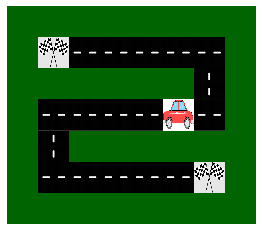

Action taken was RIGHT
Reward is: 0


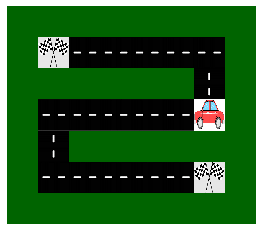

Action taken was UP
Reward is: 0


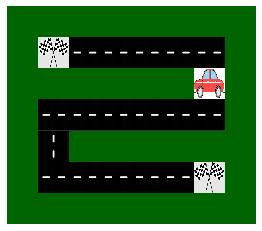

Action taken was UP
Reward is: 0


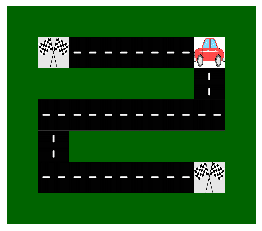

Action taken was LEFT
Reward is: 0


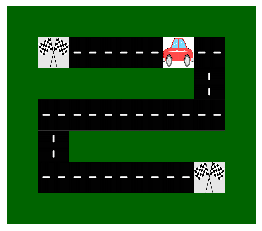

Action taken was LEFT
Reward is: 0


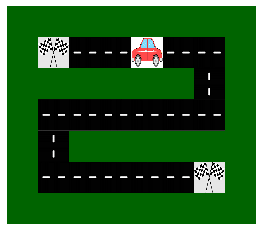

Action taken was LEFT
Reward is: 0


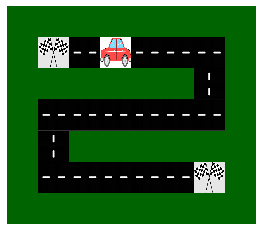

Action taken was LEFT
Reward is: 0


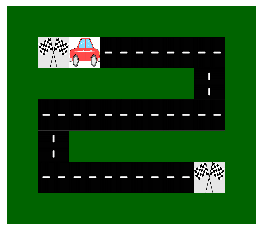

Action taken was LEFT
Reward is: 10


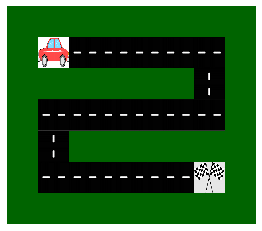

In [22]:
actions =  [RIGHT,RIGHT,UP,UP,LEFT,LEFT,LEFT,LEFT, LEFT]

env = CarNav()

obs = env.reset()
reward = 0
for action in actions:
    obs, reward, done, _ = env.step(action)
    print("Action taken was {}".format(int2action[action]))
    print("Reward is: {}".format(reward))
    plt.imshow(obs)
    plt.axis("off")
    plt.show()


Action taken was LEFT
Reward is: 0


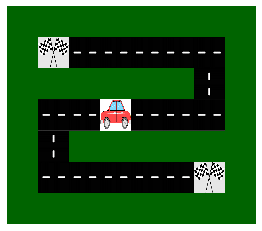

Action taken was LEFT
Reward is: 0


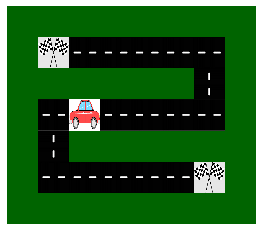

Action taken was LEFT
Reward is: 0


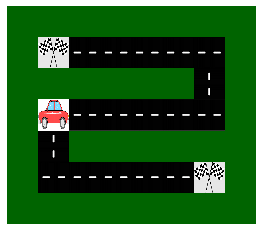

Action taken was DOWN
Reward is: 0


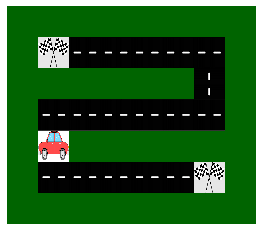

Action taken was DOWN
Reward is: 0


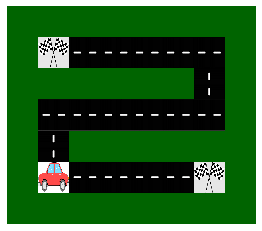

Action taken was RIGHT
Reward is: 0


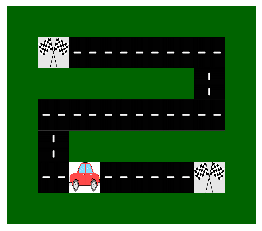

Action taken was RIGHT
Reward is: 0


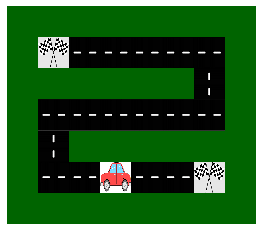

Action taken was RIGHT
Reward is: 0


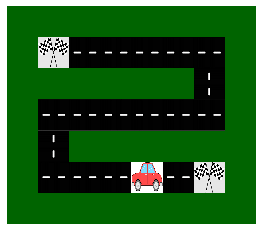

Action taken was RIGHT
Reward is: 0


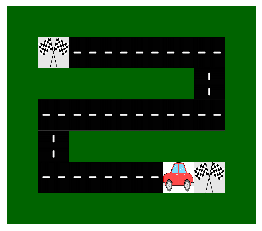

Action taken was RIGHT
Reward is: 1


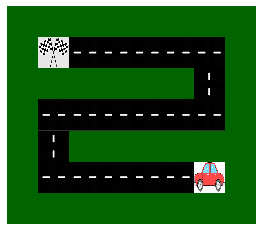

In [18]:
actions =  [LEFT,LEFT, LEFT,DOWN,DOWN,RIGHT,RIGHT,RIGHT,RIGHT,RIGHT]

env = CarNav()

obs = env.reset()
reward = 0
for action in actions:
    obs, reward, done, _ = env.step(action)
    print("Action taken was {}".format(int2action[action]))
    print("Reward is: {}".format(reward))
    plt.imshow(obs)
    plt.axis("off")
    plt.show()


Action taken was RIGHT
Reward is: 0


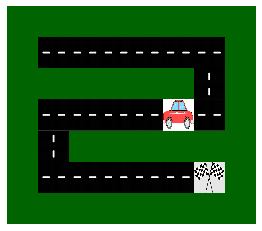

Action taken was RIGHT
Reward is: 0


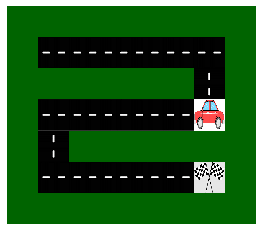

Action taken was UP
Reward is: 0


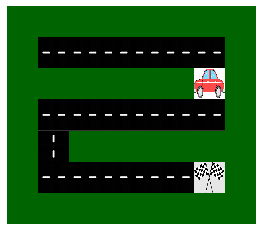

Action taken was UP
Reward is: 0


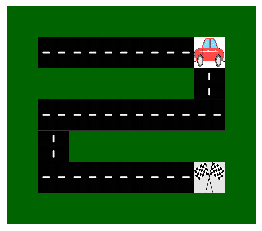

Action taken was LEFT
Reward is: 0


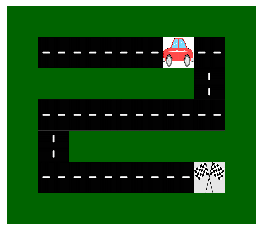

Action taken was LEFT
Reward is: 0


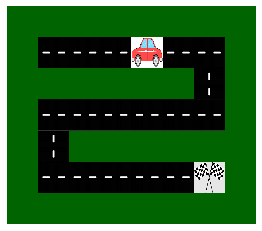

Action taken was LEFT
Reward is: 0


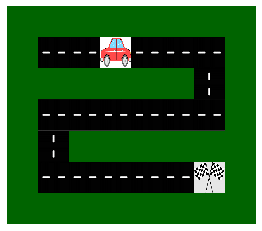

Action taken was LEFT
Reward is: 0


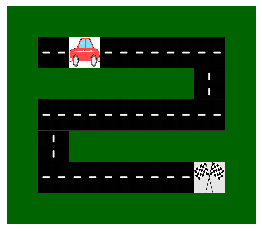

Action taken was LEFT
Reward is: 0


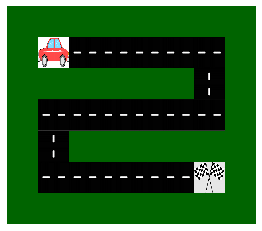

In [19]:
actions =  [RIGHT,RIGHT,UP,UP,LEFT,LEFT,LEFT,LEFT, LEFT]

env = CarNav(game_id=1)

obs = env.reset()
reward = 0
for action in actions:
    obs, reward, done, _ = env.step(action)
    print("Action taken was {}".format(int2action[action]))
    print("Reward is: {}".format(reward))
    plt.imshow(obs)
    plt.axis("off")
    plt.show()